<table style="width:100%; border:none;">
  <tr>
    <td style="width:150px; text-align:center; vertical-align:middle;">
      <img src="https://upload.wikimedia.org/wikipedia/en/6/69/Seal_of_Pablo_de_Olavide_University.png" 
           alt="Emblema UPO" 
           style="width:130px; margin:10px;">
    </td>
    <td style="text-align:center; vertical-align:middle;">
      <h2 style="margin-bottom:5px;">Universidad Pablo de Olavide</h2>
      <p><strong>Grado en Ingeniería Informática en Sistemas de Información</strong></p>
      <p><strong>Asignatura: Inteligencia Artificial</strong></p>
      <p><strong>Curso 2025/2026</strong></p>
      <h3 style="margin-top:10px;">TRABAJO #1 - Equipo 08</h3>
      <h4 style="margin-top:5px;">Dataset asignado: Nº 17</h4>
      <p><strong>Integrantes:</strong> María Pérula Gutiérrez &nbsp;·&nbsp; Jonathan Javier Quishpe Maldonado</p>
      <p><strong>Fecha de entrega:</strong> 01/12/2025</p>
    </td>
  </tr>
</table>

<hr style="margin-top:25px; margin-bottom:25px; border: 1px solid #bbb;">
<h2 style="text-align:center;">Redes Neuronales Implementación</h2>

In [1]:
# En este ejercicio implementaremos una red neuronal para el mismo problema de clasificación anterior (regresión logística): 
# Decidir si un coche es bueno para un estudiante (estudiante_ok) o no.
#
# La idea es seguir el esquema de los ejercicios de clase: forward, backprop y fmin_cg, usando las mismas 5 variables que en la regresión logística (price, km,
# economy, condition y rating) para poder comparar luego los dos modelos, ya que no es obligatorio buscar las neuronas óptimas, esto me parece más justo
# para la comparación de estos métodos. Ya que la neuronal consume mucho tiempo de ejecución.

### 1. Importaciones y lectura del dataset

In [2]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("train.csv")
df = df.rename(columns={"current price": "price"})

In [4]:
# Crearemos la variable binaria igual que en la regresión logistica
precio_medio = df["price"].mean()

df["estudiante_ok"] = (
    (df["economy"] >= 8) &
    (df["condition"] >= 3) &
    (df["price"] <= precio_medio)
).astype(int)

print("Primeras filas + estudiante_ok:\n")
print(df[["price", "km", "economy", "condition", "rating", "estudiante_ok"]].head())

Primeras filas + estudiante_ok:

      price      km  economy  condition  rating  estudiante_ok
0  351318.0   78945       14          2       1              0
1  285001.5  117220        9          9       5              1
2  215386.0  132538       15          8       2              1
3  244295.5  101065       11          3       4              1
4  531114.5   61559       12          9       3              0


### 2. Variables de entrada X y la clase y

In [5]:
# En ambos métodos uso las mismas variables y la misma definición de estudiante_ok. En la logística tuve que añadir a mano la columna de unos; en la red neuronal
#la bias ya va incluida en los pesos, así que X va sin esa columna extra.

columnas_X = ["price", "km", "economy", "condition", "rating"]
X_raw = df[columnas_X].copy()
y = df["estudiante_ok"].values.reshape(-1, 1) # (m,1)

def featureNormalize(X):
    media = X.mean()
    desv = X.std()
    X_norm = (X - media) / desv
    return X_norm, media, desv

X_norm, media_nn, desv_nn = featureNormalize(X_raw)

X_nn = X_norm.values #(m,n)
y_nn = y #(m,1)

print("\nShape X_nn:", X_nn.shape)
print("Shape y_nn:", y_nn.shape)


Shape X_nn: (1000, 5)
Shape y_nn: (1000, 1)


### 3. Función sigmoide y forward

In [6]:
#def sigmoid(z):
    #denominador = 1 + np.exp(-z)
    #g = 1 / denominador
    #return g

# Se puede simplificar
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Forward para un ejemplo X[i]
def forward(theta1, theta2, X, i):
    # capa 1: entrada + bias
    a1 = np.hstack((1, X[i])) #vector (1 + n)
    z2 = theta1 @ a1 # (hidden,)
    a2 = sigmoid(z2)

    # capa 2: oculta + bias
    a2 = np.hstack((1, a2)) #(1 + hidden)
    z3 = theta2 @ a2 # (1,)
    a3 = sigmoid(z3) #salida (entre 0 y 1)

    return a1, a2, a3

### 4. Funcion de coste (no regularizacion)

In [7]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y):
    # theta1 y theta2 desde nn_params
    theta1 = np.reshape(
        nn_params[:hidden_layer_size * (input_layer_size + 1)],
        (hidden_layer_size, input_layer_size + 1),
        order='F'
    )
    theta2 = np.reshape(
        nn_params[hidden_layer_size * (input_layer_size + 1):],
        (num_labels, hidden_layer_size + 1),
        order='F'
    )

    m = len(y)
    suma = 0.0
    y_d = pd.DataFrame(y) #fila a fila

    for i in range(X.shape[0]):
        a1, a2, h = forward(theta1, theta2, X, i)

        # coste logistico como en regresion logistica
        temp1 = y_d.iloc[i] * np.log(h)
        temp2 = (1 - y_d.iloc[i]) * np.log(1 - h)
        suma = suma + np.sum(temp1 + temp2)

    J = -suma / m
    return J

### 5. Gradiente con backpropagation

In [8]:
def nnGradFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y):
    # theta1 y theta2
    theta1 = np.reshape(
        nn_params[:hidden_layer_size * (input_layer_size + 1)],
        (hidden_layer_size, input_layer_size + 1),
        order='F'
    )
    theta2 = np.reshape(
        nn_params[hidden_layer_size * (input_layer_size + 1):],
        (num_labels, hidden_layer_size + 1),
        order='F'
    )

    m = len(y)
    y_d = pd.DataFrame(y)

    delta1 = np.zeros(theta1.shape)
    delta2 = np.zeros(theta2.shape)

    for i in range(X.shape[0]):
        # forward
        a1, a2, a3 = forward(theta1, theta2, X, i)

        # errores
        d3 = a3 - y_d.iloc[i] #capa salida
        d2 = (theta2.T @ d3) * (a2 * (1 - a2)) #capa oculta

        # acumulamos (hay que quitar la bias en d2)
        delta1 = delta1 + np.reshape(d2[1:], (hidden_layer_size, 1)) @ np.reshape(a1, (1, input_layer_size + 1))
        delta2 = delta2 + np.reshape(d3.values, (num_labels, 1)) @ np.reshape(a2, (1, hidden_layer_size + 1))

    delta1 = delta1 / m
    delta2 = delta2 / m

    grad = np.hstack((delta1.ravel(order='F'), delta2.ravel(order='F')))
    return grad

### 6. Inicializar pesos y funcion de entrenamiento

In [9]:
# Para la gráfica
cost_history = []
def guardar_coste(params):
    c = nnCostFunction(params,
                       input_layer_size,
                       hidden_layer_size,
                       num_labels,
                       X_nn,
                       y_nn.flatten())
    cost_history.append(c)

def randInitializeWeights(L_in, L_out):
    epsilon_init = 0.12
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
    return W

def training_nn(initial_theta1, initial_theta2, X_train, y_train,
                input_layer_size, hidden_layer_size, num_labels):
    maxiter = 30  # no muy alto para que no tarde mucho
    #maxiter = 200 # mejorar modelo

    nn_initial_params = np.hstack((
        initial_theta1.ravel(order='F'),
        initial_theta2.ravel(order='F')
    ))
    
    nn_params = opt.fmin_cg(
        f=nnCostFunction,
        x0=nn_initial_params,
        fprime=nnGradFunction,
        args=(input_layer_size, hidden_layer_size, num_labels, X_train, y_train.flatten()),
        maxiter=maxiter,
        callback=guardar_coste
    )

    theta1 = np.reshape(
        nn_params[:hidden_layer_size * (input_layer_size + 1)],
        (hidden_layer_size, input_layer_size + 1),
        order='F'
    )
    theta2 = np.reshape(
        nn_params[hidden_layer_size * (input_layer_size + 1):],
        (num_labels, hidden_layer_size + 1),
        order='F'
    )

    return theta1, theta2


### 8. Prediccion con la red neuronal

In [10]:
def predict_nn(theta1, theta2, X):
    m = X.shape[0]
    unos = np.ones((m, 1))

    a1 = np.hstack((unos, X))
    a2 = sigmoid(a1 @ theta1.T)
    a2 = np.hstack((unos, a2))
    h = sigmoid(a2 @ theta2.T)

    pred = np.where(h >= 0.5, 1, 0)
    return pred

### 8. Entrenamiento

In [11]:
input_layer_size = X_nn.shape[1] #5 variables de entrada
# 5 neuronas de entrada por las 5 columnas que tenemos: price, km, economy, condition y rating

hidden_layer_size = 5 # neuronas de la capa oculta
#hidden_layer_size = 10 # mejorar modelo
# Hemos puesto 5 porque es un número pequeño y razonable para este problema
# Probé algún valor cercano y funcionó parecido, así que nos quedamos con 5

num_labels = 1
# Salida binaria: 0 (no estudiante) o 1 (estudiante), con una neurona sigmoide basta

theta1_ini = randInitializeWeights(input_layer_size, hidden_layer_size)
theta2_ini = randInitializeWeights(hidden_layer_size, num_labels)

theta1_opt, theta2_opt = training_nn(
    theta1_ini, theta2_ini,
    X_nn, y_nn,
    input_layer_size, hidden_layer_size, num_labels
)

print("\nDimensiones de los pesos aprendidos:")
print("theta1_opt:", theta1_opt.shape)
print("theta2_opt:", theta2_opt.shape)

         Current function value: 0.020245
         Iterations: 30
         Function evaluations: 101
         Gradient evaluations: 101

Dimensiones de los pesos aprendidos:
theta1_opt: (5, 6)
theta2_opt: (1, 6)


/Users/jonathanquishpe/.pyenv/versions/3.13.0/lib/python3.13/site-packages/scipy/optimize/_optimize.py:1680: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_cg(f, x0, args, fprime, callback=callback, c1=c1, c2=c2,


### 7. Gráfica de convergencia

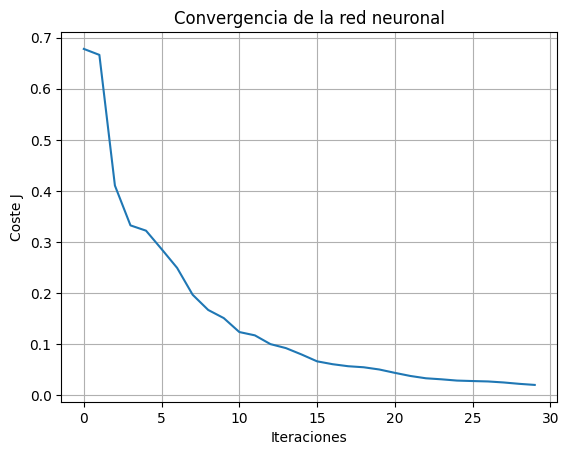

In [12]:
plt.plot(cost_history)
plt.xlabel("Iteraciones")
plt.ylabel("Coste J")
plt.title("Convergencia de la red neuronal")
plt.grid(True)
plt.show()

### 9. Evaluación: accuracy y matriz de confusion

In [13]:
y_pred_nn = predict_nn(theta1_opt, theta2_opt, X_nn)
y_real_nn = y_nn.flatten()
# Si no, no encaja
y_pred_nn = y_pred_nn.flatten()

accuracy_nn = np.mean(y_pred_nn == y_real_nn)
print("\nAccuracy de la red neuronal:", accuracy_nn)

TP_nn = np.sum((y_real_nn == 1) & (y_pred_nn == 1))
TN_nn = np.sum((y_real_nn == 0) & (y_pred_nn == 0))
FP_nn = np.sum((y_real_nn == 0) & (y_pred_nn == 1))
FN_nn = np.sum((y_real_nn == 1) & (y_pred_nn == 0))

print("/nMatriz de confusion (NN): ")
print("TP:", TP_nn, "TN:", TN_nn, "FP:", FP_nn, "FN:", FN_nn)


Accuracy de la red neuronal: 0.994
/nMatriz de confusion (NN): 
TP: 405 TN: 589 FP: 3 FN: 3


In [14]:
# Conclusión:
# La red neuronal hace exactamente el mismo problema que la regresión logistica, usando price, km, economy, condition y rating para predecir un buen coche para estudiantes.
# - La logística se entrena muy rápido y da un accuracy del 85%, que está bastante bien.
# - La red neuronal tarda un poco más (por el forward/backprop en cada iteración) pero acaba aprendiendo mucho mejor y prácticamente acierta todo.
# En resumen, la logistica es rápida y decente, y la red neuronal es lenta pero bastante más precisa en este caso.

### 9. Gráfico clasificación de los datos de nuestro dataset

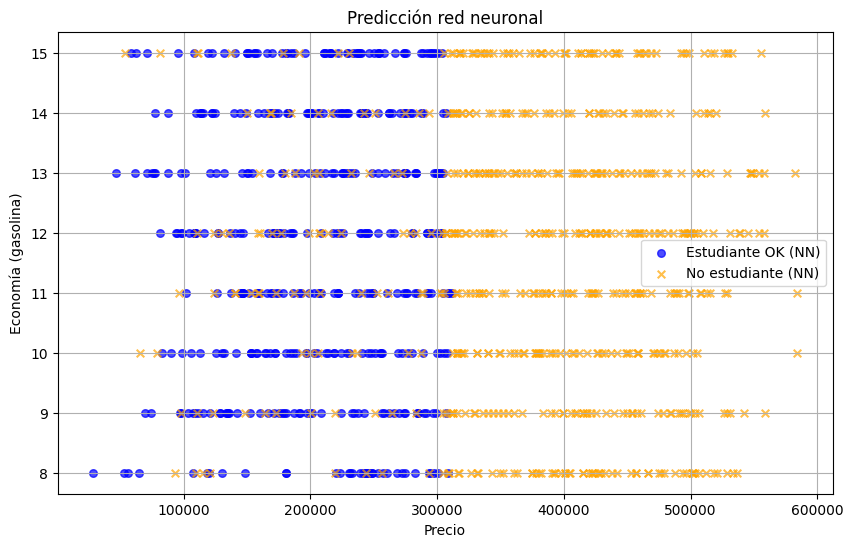

In [16]:
# Creamos el dataframe con las predicciones para comparar con la regresion logistica
df_clasif = df.copy()
df_clasif["pred_nn"] = y_pred_nn

def plot_nn_pred(df_clasif):
    df_ok = df_clasif[df_clasif["pred_nn"] == 1]
    df_no = df_clasif[df_clasif["pred_nn"] == 0]

    plt.figure(figsize=(10,6))

    plt.scatter(df_ok["price"], df_ok["economy"], c="blue", marker="o", s=30, alpha=0.7, label="Estudiante OK (NN)")
    plt.scatter(df_no["price"], df_no["economy"], c="orange", marker="x", s=30, alpha=0.7, label="No estudiante (NN)")

    plt.xlabel("Precio")
    plt.ylabel("Economía (gasolina)")
    plt.title("Predicción red neuronal")
    plt.legend()
    plt.grid(True)
    plt.show()

# Llamamos a la función
plot_nn_pred(df_clasif)